# Predict TripAdvisor Rating

## 0. Краткое описание проекта

Предсказвание ретинга ресторана

## 1. Импорты

### 1.1. Импорты библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import regex as re
%matplotlib inline
# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

### 1.2. Воспроизводимость эксперимента

In [2]:
RANDOM_SEED = 42
# для kaggle
# зафиксируем версию пакетов
#!pip freeze > requirements.txt

## 2. Собственные функции и классы

In [3]:
def split_all(lst_str):
    """ Разделяет данные на даты и коменты"""
    splited = {}
    comment = []
    date = []
    # pattern_1 = r"], ["
    pattern_2 = r"(?<=\]),*\s(?=\[)"
    for i in lst_str:
        splt = re.split(pattern_2, i)
        comment.append(splt[0])
        date.append(splt[1])
    splited['date'] = date
    splited['comment'] = comment

    return splited


def fill_nan(lsit_):
    """ Заменяет пропуски на nan"""
    out = []

    for i in lsit_:
        if len(i) == 0:
            out.append([np.nan, np.nan])
            continue
        if len(i) == 1:
            out.append([i[0], np.nan])
            continue
        out.append(i)

    return out


def parse_coment(lst_str):
    """ Возвращает список списков двух комментариев, отформатированный"""
    comment_new = []
    for i in lst_str:
        i1 = re.sub(r"\[\[", "[", i)
        i2 = re.sub(r"(\B\')", '\"', i1)
        i3 = re.sub(r"(\'\B)", '\"', i2)
        i4 = re.sub(r"\[?\]?", '', i3)
        i5 = re.sub(r"\.*", '', i4)
        i6 = re.sub(r'\", \"', "', '", i5)
        i7 = re.sub(r'^\"', "'", i6, re.MULTILINE)
        i8 = re.sub(r'\"$', "'", i7, re.MULTILINE)
        i9 = re.sub(r"\b'\b", "", i8)
        comment_new.append([re.sub(r"'", "", x)
                            for x in re.findall(r"\'.{0,}?\'", i9)])

    return fill_nan(comment_new)


def parse_date(lst_str):
    """ Возвращает список списков двух дат комментариев, 
        отформатированный"""
    date_new = []
    for i in lst_str:
        date_new.append([pd.to_datetime(x, format='%m/%d/%Y')
                         for x in re.findall(r"\d\d\/\d\d\/\d\d\d\d", i)])

    return fill_nan(date_new)


def parse_date_comments(series):
    """возвращает комментарии и даты их создания в виде полностью отформатированного датафрейма"""
    series.fillna('[[], []]', inplace=True)
    date_src = split_all(series)['date']
    comm_src = split_all(series)['comment']

    date = parse_date(date_src)
    comment = parse_coment(comm_src)

    comment_1 = [x[0] for x in comment]
    date_comment_1 = [x[0] for x in date]
    
    comment_2 = [x[1] for x in comment]
    date_comment_2 = [x[1] for x in date]
    
    return pd.DataFrame({'comment_1': comment_1,'date_comment_1': date_comment_1, 
                         'comment_2': comment_2,'date_comment_2': date_comment_2})


def parse_rangier(series):
    """ Возвращает 1, 2, 3 вместо '$','$$ - $$$','$$$$'"""
    s = (series.fillna('$$ - $$$')).copy()
    feature_price_range = {'$': 1, '$$ - $$$': 2, '$$$$': 3}

    for k, v in feature_price_range.items():
        s = s.replace(k, v)

    return s


def parse_cuisine_style(series_):
    """ Возвращает список кухонь"""
    cuisine_style = set()
    pattern = r"\'.{0,}?\'"
    for i in series_:
        if i == i:
            for j in re.findall(pattern, i):
                cuisine_style.add(j.replace('\'', ''))

    return list(cuisine_style)

def create_dummies(df, col, lst, nans):
    for item in lst:
        df[item] = df[col].apply(lambda x: nans if pd.isnull(x) else 1 if item in x else 0)
    return df[lst]

def iqr(series):
    """ Возвращает iqr"""
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    return q75-q25

### 2.1 For Data Preprocessing

## 3. Исходные Данные

In [4]:
# для kaggle
# DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')

In [5]:
# для jupyter
sample_submission = pd.read_csv('sample_submission.csv')
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')

In [6]:
# Для корректной обработки признаков объединяем трейн и тест 
# в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['Rating'] = 0  # в тесте у нас нет значения Rating, 
#                        мы его должны предсказать, 
#                        по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) 
#                        объединяем, что бы в обработку попали все
#                        признаки, и модель обучилась на всех признаках  


In [7]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
26030,id_5377,Berlin,['German'],5379.0,$$ - $$$,61.0,[['Great value and good location for kurfurst....,/Restaurant_Review-g187323-d1036947-Reviews-Be...,d1036947,1,3.5
33523,id_2570,Paris,"['French', 'Cajun & Creole', 'European']",2571.0,$$ - $$$,137.0,"[['Average', 'Very basic.'], ['01/04/2018', '1...",/Restaurant_Review-g187147-d797127-Reviews-Le_...,d797127,1,4.5
5139,id_5139,London,"['Cafe', 'Pizza', 'British', 'Halal']",15369.0,NaN,15.0,"[['SHOCKING CUSTOMER SERVICE😱', 'Disgusting.. ...",/Restaurant_Review-g186338-d4598284-Reviews-Ca...,d4598284,0,0.0
13291,id_2638,Madrid,"['European', 'Spanish', 'Mediterranean', 'Vege...",2640.0,$$ - $$$,269.0,"[['Great views & good meat.', 'Nice Lounge at ...",/Restaurant_Review-g187514-d8532773-Reviews-Ni...,d8532773,1,3.5
38410,id_1078,Dublin,"['Bar', 'Pub', 'Vegetarian Friendly']",1081.0,$,137.0,"[['Affordable and easygoing pub', 'Very afford...",/Restaurant_Review-g186605-d6877656-Reviews-Th...,d6877656,1,3.5


### 3.1. Информация о признаках

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Видно что в данных много пропусков (Cuisine Style,Price Range, 
Number of Reviews, Reviews), которые необходимо обработать. 
Также много не числовых полей, которые требуют числовой интерпретации

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

## 4. Очистка и подготовка данных

### 4.1 Подготовка данных

* переменные которые ссылаются на созданные Features будут иметь следующую форму имени ft_\<name>

#### 4.1.1. Restaurant_id

Признак "Restaurant_id" не несет полезной информации, 
так как каждая строка является уникальным случаем 
оценки конкретного заведения

=>
Столбец удалить

In [9]:
data.drop(['Restaurant_id'],axis=1,inplace=True)

#### 4.1.2. City

##### 4.1.2-1 Признак City категориальный, на данном этап предлагается создать dammy переменные

In [101]:
ft_city = pd.get_dummies(data['City'], dummy_na=True)
ft_city.isnull().value_counts()

Amsterdam  Athens  Barcelona  Berlin  Bratislava  Brussels  Budapest  Copenhagen  Dublin  Edinburgh  Geneva  Hamburg  Helsinki  Krakow  Lisbon  Ljubljana  London  Luxembourg  Lyon   Madrid  Milan  Munich  Oporto  Oslo   Paris  Prague  Rome   Stockholm  Vienna  Warsaw  Zurich  nan  
False      False   False      False   False       False     False     False       False   False      False   False    False     False   False   False      False   False       False  False   False  False   False   False  False  False   False  False      False   False   False   False    50000
dtype: int64

In [11]:
ft_city

,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,...,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,NaN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


##### 4.1.2.1 For Data Preprocessing см п.2.1

In [12]:
def step_1(input_df):
    return pd.get_dummies(input_df['City'], dummy_na=True).copy()

#### 4.1.3. Cuisine Style

In [13]:
cuisine_style_lst = parse_cuisine_style(data['Cuisine Style'])


# def find_item(cell):
#     if cell == cell:
#         if item in cell:
#             return 1
#         return 0
#     return np.nan


# for item in cuisine_style_lst:
#     df_copy_1[item] = df_copy_1['Cuisine Style'].apply(find_item)

# cuisines_dammy_feature = df_copy_1[cuisine_style_lst].copy()

In [14]:
ft_cuisins = create_dummies(data, "Cuisine Style", cuisine_style_lst, 0).copy()

In [15]:
ft_cuisins

,Cajun & Creole,Singaporean,Fusion,Native American,Mexican,Canadian,Latin,Argentinean,Malaysian,Romanian,...,Bar,French,Soups,Gastropub,Cuban,Indian,Thai,Vietnamese,Dutch,Indonesian
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 4.1.3.1 For Data Preprocessing см п.2.1


In [16]:
def step_2(input_df):
    return create_dummies(data, "Cuisine Style", cuisine_style_lst, 0).copy()

#### 4.1.4. Ranking

необходимо стандартизовать этот признак по городам, потому что лучший 
ресторан в одном городе должен быть равен лучшему ресторану в другом городе.

=> предлагаю просто каждое значение ранга разделить на максимальное значение в этом городе и умножить на 100


In [17]:
# список городов
cities = data['City'].unique()


In [18]:
# пробую в лоб (очень долго)
# data['max_ranking'] = data['City'].apply(lambda x: data[data['City'] == x]['Ranking'].max())

In [19]:
df_city_maxranking = pd.DataFrame({'City': list(cities), 'maxranking': [
                                  data[data['City'] == i]
                                  ['Ranking'].max() for i in cities]})

In [20]:
testo_df = pd.merge(data[['City','Ranking']],df_city_maxranking, how='left', on='City')

In [21]:
# намного быстрее
data['st_Ranking'] = (testo_df['Ranking']/testo_df['maxranking'])*100
data['st_Ranking'].isnull().value_counts()

False    50000
Name: st_Ranking, dtype: int64

In [22]:
ft_rank = data['st_Ranking'].copy()

##### 4.1.4.1. For Data Preprocessing см п.2.1
    

In [23]:
def step_3(input_df):
    cities = input_df['City'].unique()
    f_city_maxranking = pd.DataFrame({'City': list(cities), 'maxranking': [
                                  input_df[input_df['City'] == i]
                                  ['Ranking'].max() for i in cities]})
    testo_df = pd.merge(data[['City','Ranking']],df_city_maxranking, how='left', on='City')
    input_df['st_Ranking'] = (testo_df['Ranking']/testo_df['maxranking'])*100
    return input_df['st_Ranking'].copy()

#### 4.1.5. Price Range

категориальный ординальный признак, поэтому применяем Label Encoding

In [24]:
pd.Series([data[data['City'] == i]['Price Range'].value_counts(ascending=True).index[-1] for i in cities]).value_counts()

$$ - $$$    31
dtype: int64

как видно, во всех городах самым частым уровнем цены является средний, поэтому для обучения заменим все пропуски на это же значение

In [25]:
ft_price = parse_rangier(data['Price Range'])
ft_price.isnull().value_counts()

False    50000
Name: Price Range, dtype: int64

#### 4.1.5.1. For Data Preprocessing см п.2

In [26]:
def step_4(input_df):
    return parse_rangier(input_df['Price Range'])

#### 4.1.6. Reviews

Разделим комментарии и даты для более удобной обработки,
на будущее у нас останутся комментарии, но в настоящем мы не владем NLP методами анализа естественного языка. поэтому нам важны только есть или нет комментарий


In [27]:
df_dates = parse_date_comments(data['Reviews'])

In [28]:
df_dates = df_dates.copy() # скопируем для безболезненных манипуляций, 
#                            и создания признаков

In [29]:
df_dates['comment_1'].fillna('', inplace = True )
df_dates['comment_2'].fillna('', inplace = True )
df_dates['comment_1'] = df_dates['comment_1'].apply(lambda x: int(bool(x)))
df_dates['comment_2'] = df_dates['comment_2'].apply(lambda x: int(bool(x)))
df_dates['pseudo_n_rev']  = df_dates['comment_1'] + df_dates['comment_2']

In [30]:
# некоторые даты не соответсвуют условию  что первый комментарий новее чем второй
# исправим  это
df_dates['new_date'] = df_dates[['date_comment_1','date_comment_2']].apply(
                        lambda x: x[1] if x[1] > x[0] else x[0], axis = 1)
df_dates['late_date']= df_dates[['date_comment_1','date_comment_2']].apply(
                        lambda x: x[0] if x[1] > x[0] else x[1], axis = 1)
df_dates['freq'] = (df_dates['new_date'] - df_dates['late_date']).dt.days
df_dates['fresh'] = (df_dates['new_date'].max() - df_dates['new_date']).dt.days

<AxesSubplot:>

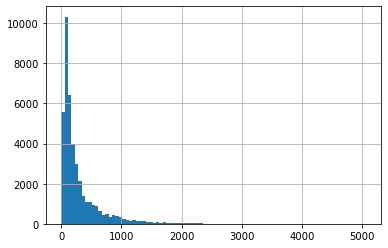

In [31]:
df_dates['fresh'].hist(bins= 90)

<AxesSubplot:>

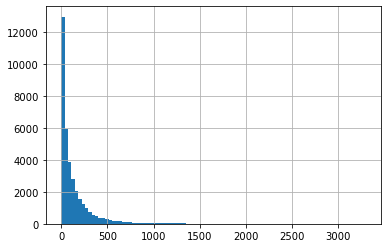

In [32]:
df_dates['freq'].hist(bins= 90)

In [33]:
df_dates.drop(columns =['comment_1','date_comment_1','comment_2','date_comment_2'], inplace=True)

In [34]:
df_dates

,pseudo_n_rev,new_date,late_date,freq,fresh
0,0,NaT,NaT,NaN,NaN
1,2,2017-12-05,2017-10-29,37.0,83.0
2,2,2017-12-28,2017-12-06,22.0,60.0
3,2,2017-12-06,2017-11-22,14.0,82.0
4,2,2018-02-08,2018-01-24,15.0,18.0
...,...,...,...,...,...
49995,2,2017-12-16,2017-11-12,34.0,72.0
49996,2,2017-12-21,2017-12-12,9.0,67.0
49997,2,2016-11-03,2008-04-12,3127.0,480.0
49998,2,2017-07-11,2017-06-18,23.0,230.0


#### 4.1.7. Number of Reviews

1. Необходимо заполнить пропуски истинными значениями если такие есть(если коментарии есть а количество комментариев 0 значит нужно поставить столько сколько есть комментариев, в случае если не использовать парсинг)
2. Поэтому этот шаг делать только после того как будет обработан столбец "Reviews"


In [35]:
df_dates['Number of Reviews'] = data['Number of Reviews']

In [36]:
df_dates['freq'].fillna(0, inplace=True)
df_dates['fresh'].fillna(0, inplace=True)

In [37]:
df_dates.fillna('NaN', inplace=True)

In [38]:
df_dates['Number of Reviews'] = df_dates[['Number of Reviews','pseudo_n_rev']].apply(
                                lambda x: x[1] if x[0]=='NaN' else x[0], axis=1)

In [39]:
df_dates

,pseudo_n_rev,new_date,late_date,freq,fresh,Number of Reviews
0,0,NaN,NaN,0.0,0.0,4.0
1,2,2017-12-05 00:00:00,2017-10-29 00:00:00,37.0,83.0,97.0
2,2,2017-12-28 00:00:00,2017-12-06 00:00:00,22.0,60.0,28.0
3,2,2017-12-06 00:00:00,2017-11-22 00:00:00,14.0,82.0,202.0
4,2,2018-02-08 00:00:00,2018-01-24 00:00:00,15.0,18.0,162.0
...,...,...,...,...,...,...
49995,2,2017-12-16 00:00:00,2017-11-12 00:00:00,34.0,72.0,79.0
49996,2,2017-12-21 00:00:00,2017-12-12 00:00:00,9.0,67.0,542.0
49997,2,2016-11-03 00:00:00,2008-04-12 00:00:00,3127.0,480.0,4.0
49998,2,2017-07-11 00:00:00,2017-06-18 00:00:00,23.0,230.0,70.0


In [40]:
ft_reviews = df_dates[['freq','fresh','Number of Reviews','pseudo_n_rev']].copy()

##### 4.1.5.1. For Data Preprocessing см п.2

In [41]:
def step_5(input_df):
    # 1
    df_dates = parse_date_comments(input_df['Reviews']).copy()
    # 2
    df_dates['comment_1'].fillna('', inplace=True)
    df_dates['comment_2'].fillna('', inplace=True)
    df_dates['comment_1'] = df_dates['comment_1'].apply(lambda x: int(bool(x)))
    df_dates['comment_2'] = df_dates['comment_2'].apply(lambda x: int(bool(x)))
    df_dates['pseudo_n_rev'] = df_dates['comment_1'] + df_dates['comment_2']
    # 3
    df_dates['new_date'] = df_dates[['date_comment_1', 'date_comment_2']].apply(
        lambda x: x[1] if x[1] > x[0] else x[0], axis=1)
    df_dates['late_date'] = df_dates[['date_comment_1', 'date_comment_2']].apply(
        lambda x: x[0] if x[1] > x[0] else x[1], axis=1)
    df_dates['freq'] = (df_dates['new_date'] - df_dates['late_date']).dt.days
    df_dates['fresh'] = (df_dates['new_date'].max() -
                         df_dates['new_date']).dt.days
    # 4
    df_dates.drop(columns=['comment_1', 'date_comment_1',
                           'comment_2', 'date_comment_2'], inplace=True)
    # 5
    df_dates['Number of Reviews'] = input_df['Number of Reviews']
    # 6
    df_dates['freq'].fillna(0, inplace=True)
    df_dates['fresh'].fillna(0, inplace=True)
    # 7
    df_dates.fillna('NaN', inplace=True)
    # 8
    df_dates['Number of Reviews'] = df_dates[['Number of Reviews', 'pseudo_n_rev']].apply(
        lambda x: x[1] if x[0] == 'NaN' else x[0], axis=1)
    # 9
    return df_dates[['freq','fresh','Number of Reviews','pseudo_n_rev']].copy()

#### 4.1.8. Остальные признаки просто удалим

### 4.2 Работа с Пропусками
на шаге 4.1 нам удалось также очистить данные от пропусков

## 5. Feature engenearing и создание итогового датасета

аналогично на шаге 4.1 нам удалось отобрать и создать новые признаки для модели

In [42]:
sample = data[['sample']].copy()
rating  = data[['Rating']].copy()
df_done = pd.concat([rating,ft_city,ft_cuisins,ft_rank,ft_price,ft_reviews,sample], axis=1)


In [43]:
df_done

,Rating,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,...,Vietnamese,Dutch,Indonesian,st_Ranking,Price Range,freq,fresh,Number of Reviews,pseudo_n_rev,sample
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,92.685543,2,0.0,0.0,4.0,0,0
1,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,9.290096,2,37.0,83.0,97.0,2,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,45.866365,2,22.0,60.0,28.0,2,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,10.149599,3,14.0,82.0,202.0,2,0
4,0.0,0,0,0,0,1,0,0,0,0,...,0,0,0,4.161980,3,15.0,18.0,162.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4.5,0,0,0,0,0,0,0,0,0,...,0,0,0,7.968127,2,34.0,72.0,79.0,2,1
49996,3.5,0,0,0,0,0,0,0,0,0,...,0,0,0,45.338195,2,9.0,67.0,542.0,2,1
49997,4.5,0,0,0,0,0,0,0,0,0,...,0,0,0,67.045455,2,3127.0,480.0,4.0,2,1
49998,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,29.758589,2,23.0,230.0,70.0,2,1


## 6. EDA

### 6.1 Ranking

<AxesSubplot:>

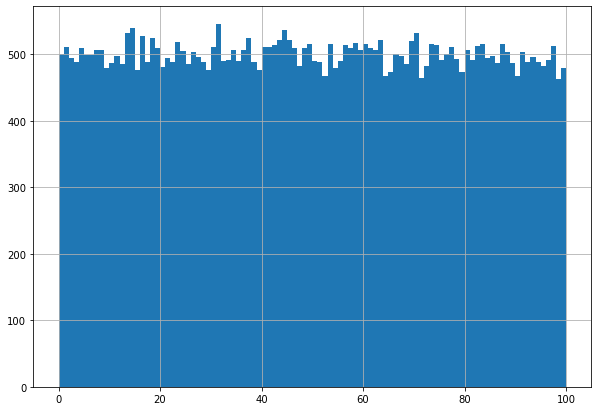

In [44]:
plt.rcParams['figure.figsize'] = (10,7)
df_done['st_Ranking'].hist(bins=100)

# после стандартизации мы видим однаковую картину по городам 


### 6.2 Распределение целевой переменной

<AxesSubplot:>

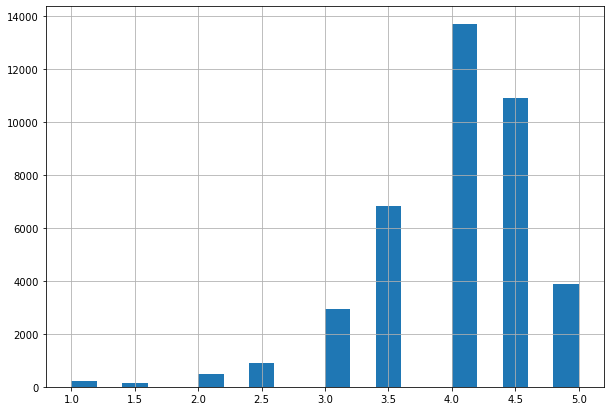

In [45]:
train = data[data['sample'] == 1]
train['Rating'].hist(bins=20)

<AxesSubplot:>

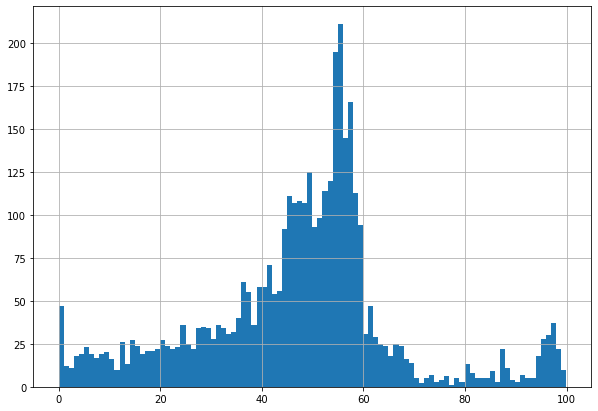

In [46]:
train['st_Ranking'][train['Rating'] == 5].hist(bins=100)


<AxesSubplot:>

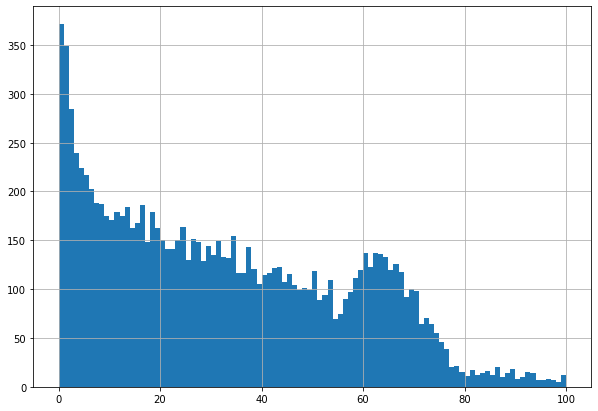

In [47]:
train['st_Ranking'][(train['Rating'] < 5) & (train['Rating'] > 4)].hist(bins=100)

<AxesSubplot:>

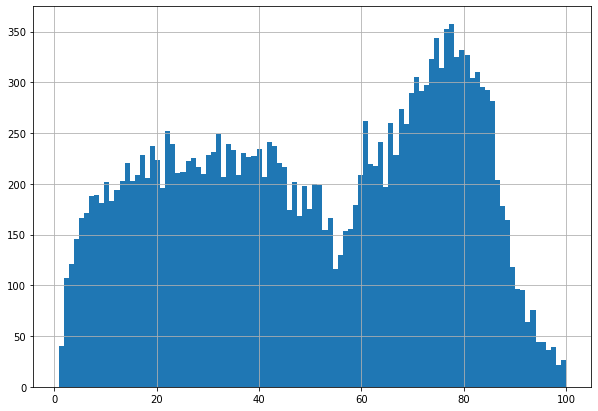

In [48]:
train['st_Ranking'][(train['Rating'] <= 4) & (train['Rating'] > 3)].hist(bins=100)

<AxesSubplot:>

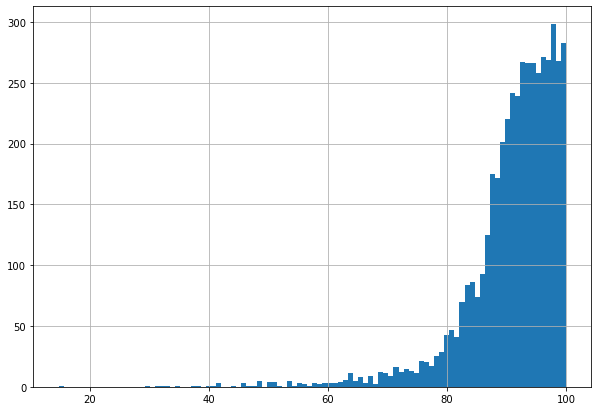

In [49]:
train['st_Ranking'][(train['Rating'] <= 3)].hist(bins=100)

### 6.3 Корреляция признаков

<AxesSubplot:>

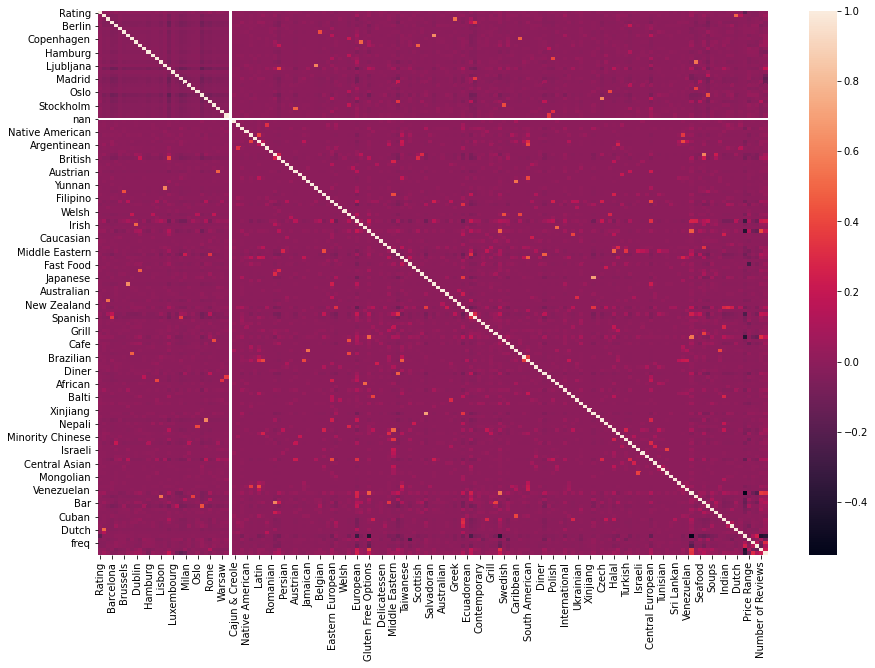

In [50]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df_done.drop(['sample'], axis=1).corr(),)

## 7. Data Preprocessing

In [53]:
def preproc_data(input_df):
    sample_fn = input_df[['sample']].copy()
    rating_fn  = input_df[['Rating']].copy()
    df_output = pd.concat([rating_fn,
                           step_1(input_df),
                           step_2(input_df),
                           step_3(input_df),
                           step_4(input_df),
                           step_5(input_df),
                           sample_fn], axis=1)
    return df_output
    

In [56]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Rating,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,...,Vietnamese,Dutch,Indonesian,st_Ranking,Price Range,freq,fresh,Number of Reviews,pseudo_n_rev,sample
11851,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,96.874240,1,248.0,137.0,21.0,2,1
27954,4.5,0,0,0,0,0,0,0,0,0,...,0,0,0,55.929919,2,0.0,0.0,12.0,0,1
32171,2.5,0,0,0,0,0,0,0,0,0,...,0,0,0,95.518122,2,72.0,671.0,34.0,2,1
45980,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,34.365118,2,9.0,57.0,116.0,2,1
22748,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,42.311366,1,103.0,245.0,20.0,2,1
552,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,20.463228,2,51.0,275.0,41.0,2,0
22991,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,23.783751,1,4.0,225.0,106.0,2,1
9935,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,35.659312,1,10.0,236.0,68.0,2,0
14848,4.5,0,0,0,0,0,0,0,0,0,...,0,0,0,2.252858,2,23.0,130.0,586.0,2,1
28527,4.5,0,0,0,0,0,0,0,0,0,...,0,0,0,22.454308,2,0.0,327.0,28.0,1,1


## 8. Данные для Модели

In [57]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [58]:
# Разделим данные на еще один тест и трейн, для валидации.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [59]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 164), (40000, 164), (40000, 163), (32000, 163), (8000, 163))

## 9. Model

In [61]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [62]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

### 9.1 MAE

In [64]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20264812499999998


<AxesSubplot:>

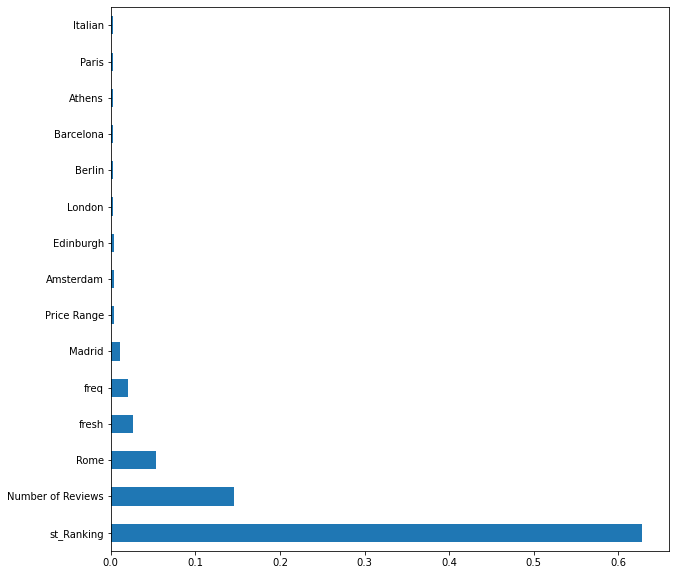

In [65]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## 10. Submission

In [95]:
test_data.sample(10)

,Rating,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,...,Thai,Vietnamese,Dutch,Indonesian,st_Ranking,Price Range,freq,fresh,Number of Reviews,pseudo_n_rev
9675,0.0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,53.103872,1,2.0,77.0,43.0,2
3252,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,75.167144,2,390.0,662.0,9.0,2
9452,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10.061878,2,34.0,33.0,708.0,2
4480,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,82.236377,1,87.0,362.0,9.0,2
9260,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,76.246655,2,0.0,594.0,1.0,1
4575,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,98.199203,2,0.0,0.0,12.0,0
1552,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,90.354028,2,0.0,0.0,60.0,0
2715,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,15.057915,2,30.0,150.0,136.0,2
3484,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,41.680856,2,17.0,78.0,267.0,2
1206,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,45.593625,2,0.0,356.0,31.0,1


In [96]:
test_data = test_data.drop(['Rating'], axis=1)

In [97]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [98]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [99]:
predict_submission

array([3.05 , 4.31 , 4.445, ..., 3.125, 4.495, 4.3  ])

In [100]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.050
1,id_1,4.310
2,id_2,4.445
3,id_3,4.335
4,id_4,4.500
5,id_5,4.470
6,id_6,3.085
7,id_7,3.360
8,id_8,4.220
9,id_9,4.695
